# Autoencoders


In [1]:
import sys
sys.path.append('..')

In [107]:
import torch
from torch import nn
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from collections import OrderedDict
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from typing import Union
from ModuleUtils import enhance_plot
%matplotlib inline

## Simple MLP Encoder

In [3]:
class HiddenBlock(nn.Module):
    
    def __init__(self, 
                 input_size: int, 
                 hidden_layers: tuple[int:] = None,
                 dropout: float = 0.2):
        super(HiddenBlock, self).__init__()
        if hidden_layers is None:
            self.hidden_layers = []
        elif isinstance(hidden_layers, int):
            self.hidden_layers = [hidden_layers]
        else:
            self.hidden_layers = hidden_layers
        self.input_size = input_size
        self.num_of_layers = len(self.hidden_layers)
        self.dropout = dropout
        
        self.dense_layers = self._build_dense_layers()
    
    def _build_dense_layers(self):
        layers = []
        if self.num_of_layers == 0:
            return nn.Identity()
        else:
            in_features = self.input_size
            for index, layer_size in enumerate(self.hidden_layers, start=1):
                layers.append((
                    f'dense_layer{index}',
                    nn.Sequential(
                        nn.Linear(in_features=in_features,
                                  out_features=layer_size),
                        nn.ReLU(),
                        nn.LayerNorm(layer_size),
                        nn.Dropout(p=self.dropout)
                    )
                ))
                in_features = layer_size
        return nn.Sequential(OrderedDict(layers))
    
    def forward(self, x):
        return self.dense_layers(x)
    
    def summary(self):
        print(self)


class DenseEncoder(HiddenBlock):
    
    def __init__(self,
                 input_shape: tuple[int, int, int],
                 hidden_layers: tuple[int:] = None,
                 latent_space_dim: int = 2,
                 dropout: float = 0.2):
        self.input_shape = input_shape
        input_size = input_shape[0] * input_shape[1] * input_shape[2]
        super(DenseEncoder, self).__init__(input_size=input_size,
                                           hidden_layers=hidden_layers,
                                           dropout=dropout)
        self.latent_space_dim = latent_space_dim
        
        self.flatten = nn.Flatten()
        self.output_layer = self._build_output_layer()
    
    def _build_output_layer(self):
        if self.num_of_layers == 0:
            in_features = self.input_size
        else:
            in_features = self.hidden_layers[-1]
        return nn.Linear(in_features=in_features,
                         out_features=self.latent_space_dim)
    
    def forward(self, x):
        return self.output_layer(self.dense_layers(self.flatten(x)))


class DenseDecoder(HiddenBlock):
    
    def __init__(self,
                 output_shape: tuple[int, int, int],
                 hidden_layers: tuple[int:] = None,
                 latent_space_dim: int = 2,
                 dropout: float = 0.2):
        super(DenseDecoder, self).__init__(input_size=latent_space_dim,
                                           hidden_layers=hidden_layers,
                                           dropout=dropout)
        self.output_shape = output_shape
        self.latent_space_dim = latent_space_dim
        self.output_layer = self._build_output_layer()
    
    def _build_output_layer(self):
        if self.num_of_layers == 0:
            in_features = self.latent_space_dim
        else:
            in_features = self.hidden_layers[-1]
        out_features = self.output_shape[0] * self.output_shape[1] * self.output_shape[2]
        return nn.Sequential(nn.Linear(in_features=in_features,
                                       out_features=out_features),
                             nn.Sigmoid())
    
    def forward(self, x):
        return self.output_layer(self.dense_layers(x)).view(x.size(0), *self.output_shape)

In [4]:
dummy_tensor = torch.randn(1, 1, 28, 28)
input_shape = [1, 28, 28]
hidden_layers = [256]
latent_space_dim = 2
DenseEncoder(input_shape).summary()

DenseEncoder(
  (dense_layers): Identity()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (output_layer): Linear(in_features=784, out_features=2, bias=True)
)


In [5]:
model = DenseEncoder(
    input_shape=input_shape,
    hidden_layers=hidden_layers,
    latent_space_dim=latent_space_dim
)
model.summary()
latent_dummy_tensor = model(dummy_tensor)
latent_dummy_tensor.shape

DenseEncoder(
  (dense_layers): Sequential(
    (dense_layer1): Sequential(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): ReLU()
      (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (3): Dropout(p=0.2, inplace=False)
    )
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (output_layer): Linear(in_features=256, out_features=2, bias=True)
)


torch.Size([1, 2])

In [6]:
model = DenseDecoder(
    output_shape=input_shape,
    hidden_layers=hidden_layers[::-1],
    latent_space_dim=latent_space_dim
)
model.summary()
model(latent_dummy_tensor).shape

DenseDecoder(
  (dense_layers): Sequential(
    (dense_layer1): Sequential(
      (0): Linear(in_features=2, out_features=256, bias=True)
      (1): ReLU()
      (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (3): Dropout(p=0.2, inplace=False)
    )
  )
  (output_layer): Sequential(
    (0): Linear(in_features=256, out_features=784, bias=True)
    (1): Sigmoid()
  )
)


torch.Size([1, 1, 28, 28])

Now let's build an Autoencoder

In [7]:
class DenseAutoencoder(nn.Module):
    
    def __init__(self,
                 input_shape: tuple[int, int, int],
                 encoder_hidden_layers: tuple[int:] = None,
                 decoder_hidden_layers: tuple[int:] = None,
                 latent_space_dim: int = 2,
                 dropout: float = 0.1):
        super(DenseAutoencoder, self).__init__()
        
        self.encoder = DenseEncoder(input_shape=input_shape,
                                    hidden_layers=encoder_hidden_layers,
                                    latent_space_dim=latent_space_dim,
                                    dropout=dropout) 
        
        if decoder_hidden_layers is None:
            decoder_hidden_layers = self.encoder.hidden_layers[::-1]
        self.decoder = DenseDecoder(output_shape=input_shape,
                                    hidden_layers=decoder_hidden_layers,
                                    latent_space_dim=latent_space_dim,
                                    dropout=dropout)
    
    def forward(self, x):
        return self.decoder(self.encoder(x))
    
    def summary(self):
        print(self)

In [8]:
model = DenseAutoencoder(
    input_shape=input_shape,
    encoder_hidden_layers=hidden_layers,
    latent_space_dim=latent_space_dim
)
model.summary()
model(dummy_tensor).shape

DenseAutoencoder(
  (encoder): DenseEncoder(
    (dense_layers): Sequential(
      (dense_layer1): Sequential(
        (0): Linear(in_features=784, out_features=256, bias=True)
        (1): ReLU()
        (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (output_layer): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): DenseDecoder(
    (dense_layers): Sequential(
      (dense_layer1): Sequential(
        (0): Linear(in_features=2, out_features=256, bias=True)
        (1): ReLU()
        (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
    (output_layer): Sequential(
      (0): Linear(in_features=256, out_features=784, bias=True)
      (1): Sigmoid()
    )
  )
)


torch.Size([1, 1, 28, 28])

In [9]:
summary(model, input_size=tuple(input_shape), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
         LayerNorm-4                  [-1, 256]             512
           Dropout-5                  [-1, 256]               0
            Linear-6                    [-1, 2]             514
      DenseEncoder-7                    [-1, 2]               0
            Linear-8                  [-1, 256]             768
              ReLU-9                  [-1, 256]               0
        LayerNorm-10                  [-1, 256]             512
          Dropout-11                  [-1, 256]               0
           Linear-12                  [-1, 784]         201,488
          Sigmoid-13                  [-1, 784]               0
     DenseDecoder-14            [-1, 1,

## Training the Autoencoder
Let's compare one hidden layer and their different sizes

In [10]:
DATA_PATH = '../Datasets/data'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307, ), (0.3081, ))
])
mnist_train = datasets.MNIST(root=DATA_PATH, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root=DATA_PATH, train=False, download=True, transform=transform)
mnist_test[0][0].shape

torch.Size([1, 28, 28])

In [11]:
LEARNING_RATE = 0.001
BATCH_SIZE = 512
NUM_EPOCHS = 30
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cpu')

colors = ['red', 'lime', 'white', 'cyan', 'yellow', 'violet']
hidden_layers_list = [[2], [16], [64], [512], [1024], [4092]]
latent_space_dim = 2

In [12]:
def autoencoder_train_loop(model, dataloader, criterion,
                           optimizer, device, epochs):
    loss_list = []
    model.train()
    with tqdm(range(epochs)) as pbar:
        for _ in pbar:
            loss_train = 0
            for images, _ in dataloader:
                images = images.to(device)
                outputs = model(images)
                loss = criterion(outputs, images)
                loss_train += (loss_value := loss.item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                pbar.set_postfix(loss=loss_value)
            loss_list.append(loss_train / len(dataloader))
    return loss_list

In [13]:
loss_results = {}
trained_models = {}
model_path = './models/9.1-DenseAutoencoders/'
for hidden_layers in hidden_layers_list:
    architecture = hidden_layers + [latent_space_dim]
    print(f'{architecture}:')
    model_title = f'Architecture: {architecture}'
    model_path_file = model_path + model_title
    
    autoencoder = DenseAutoencoder(
        input_shape=input_shape,
        encoder_hidden_layers=hidden_layers,
        latent_space_dim=latent_space_dim
    ).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)
    train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
    
    loss_results[f'{architecture}'] = autoencoder_train_loop(
        model=autoencoder, 
        dataloader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=DEVICE,
        epochs=NUM_EPOCHS
    )
    trained_models[model_title] = autoencoder
    # torch.save(obj=autoencoder.state_dict(), 
    #            f=f'./models/9.1-DenseAutoencoders/DenseAutoencoder{architecture}.pth')

[2]:


100%|██████████| 30/30 [05:12<00:00, 10.40s/it, loss=0.823]


[16]:


100%|██████████| 30/30 [05:09<00:00, 10.31s/it, loss=0.721]


[64]:


100%|██████████| 30/30 [05:07<00:00, 10.25s/it, loss=0.66] 


[512]:


100%|██████████| 30/30 [05:19<00:00, 10.64s/it, loss=0.635]


[1024]:


100%|██████████| 30/30 [05:31<00:00, 11.05s/it, loss=0.629]


[4092]:


100%|██████████| 30/30 [05:19<00:00, 10.66s/it, loss=0.627]


In [14]:
def plot_loss(figure, axes, epochs, loss_dict, config_dict, colors=None, **enhancements):
    if colors is None:
        colors = [None] * (len(loss_dict))
    with plt.style.context('cyberpunk'):
        x_axis = range(1, epochs + 1)
        for (loss_type, loss), color in zip(loss_dict.items(), colors):
            axes.plot(x_axis, loss, label=f'{loss_type}: {min(loss):.3f}', color=color)
        axes.set(**config_dict)
        axes.legend()
        enhance_plot(figure, axes, **enhancements)

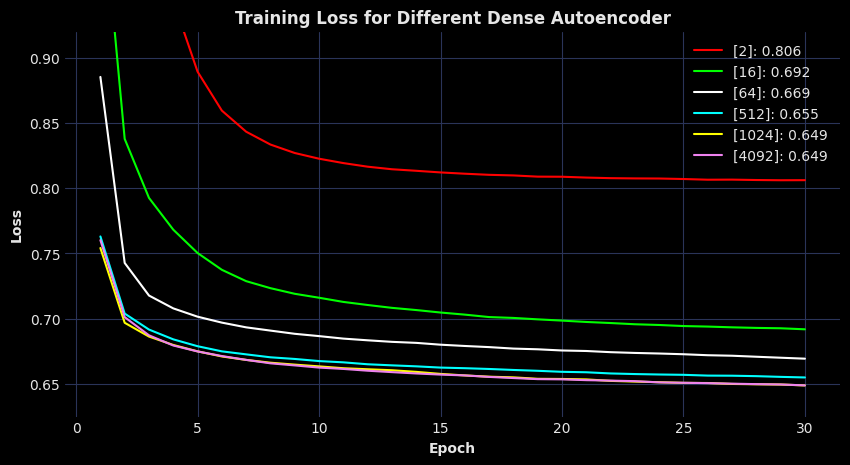

In [15]:
if loss_results:    
    with plt.style.context('cyberpunk'):
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        config = {'title': f'Training Loss for Different Dense Autoencoder', 
                  'xlabel': 'Epoch', 'ylabel': 'Loss', 'ylim': [0.625, 0.92]}
        plot_loss(fig, ax, NUM_EPOCHS, loss_results, config, colors)

Let's try to reconstruct the images with trained model

In [16]:
def sample_random_digits(mnist_dataset, seed=42):
    torch.manual_seed(seed)
    targets = mnist_dataset.targets.numpy()
    samples = {}
    for digit in range(10):
        indices = [i for i, label in enumerate(targets) if label == digit]
        chosen_idx = np.random.choice(indices)
        samples[digit] = mnist_dataset[chosen_idx][0]
    return samples

def compare_generated_to_original_mnist(model_dict, mnist_dataset):
    n_rows = len(model_dict) + 1
    figure, axes = plt.subplots(n_rows, 10, figsize=(15, 2 * n_rows))
    image_dict = sample_random_digits(mnist_dataset, seed=42)
    for digit, img in image_dict.items():
        axes[0, digit].imshow(img.permute(1, 2, 0).numpy(), cmap='Greys')
        for i, model in enumerate(model_dict.values(), start=1):
            model.eval()
            reconstruction = model.cpu()(img.unsqueeze(0)).squeeze(0).detach()
            axes[i, digit].imshow(reconstruction.permute(1, 2, 0).numpy(), cmap='Greys')
    for ax in axes.ravel():
        ax.axis(False)
    for i, model_name in enumerate(['Original'] + list(model_dict.keys())):
        x_coord = axes[i, 0].get_position().y1 + 0.01
        figure.text(0.5, x_coord, model_name, ha='center', va='center', fontsize=18)

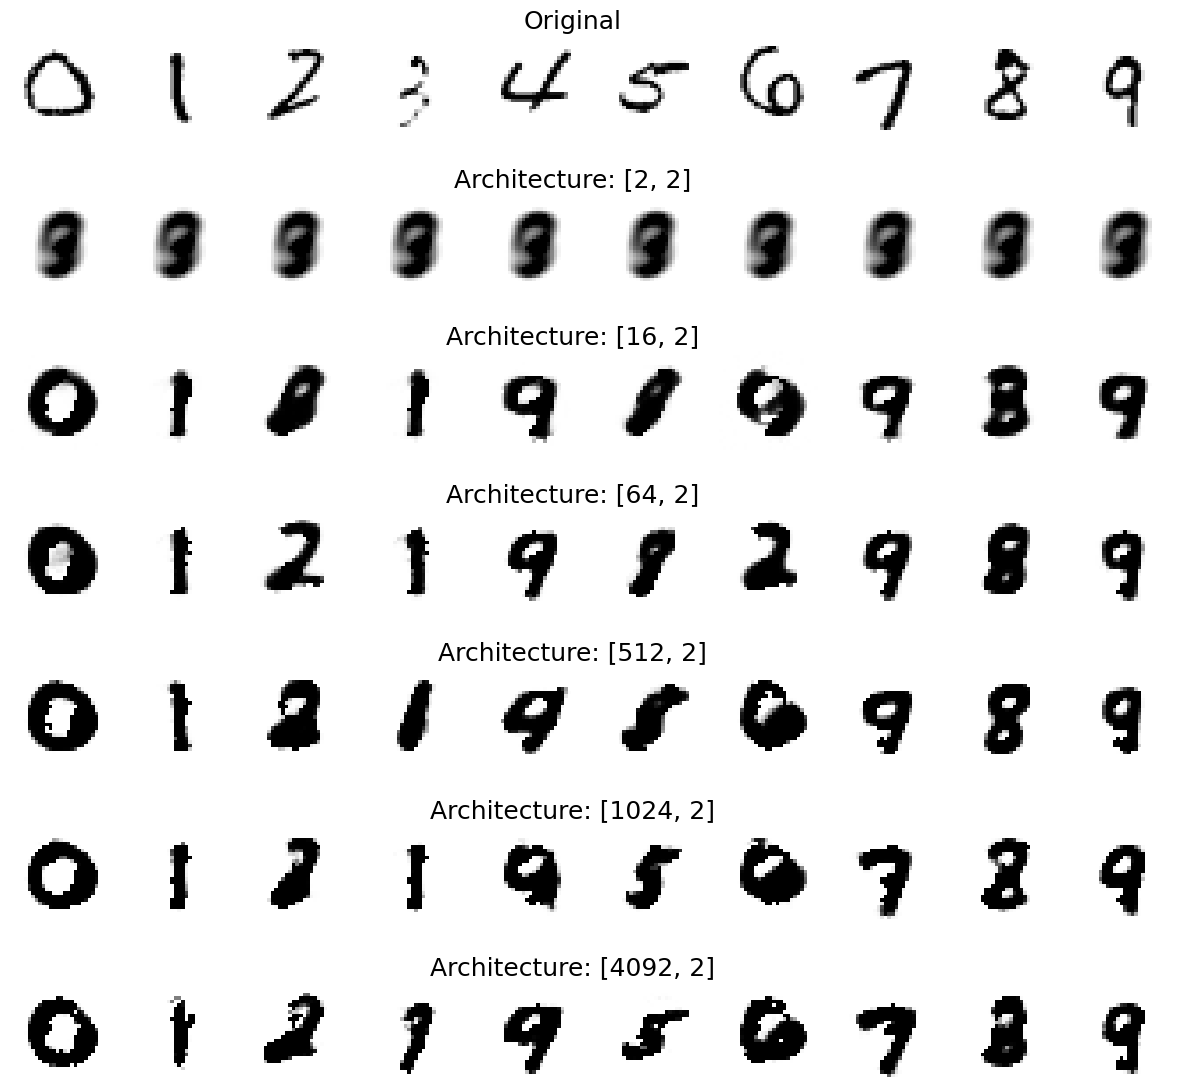

In [17]:
compare_generated_to_original_mnist(trained_models, mnist_test)

We can see that networks with more parameters stop confusing 7 with 9 for example

In [76]:
def get_latent_space_points(model, dataset):
    model = model.cpu().eval()
    points = []
    label_list = []
    for image, label in tqdm(dataset):
        point = model(image.unsqueeze(0)).squeeze(0).detach().numpy()
        points.append(point)
        label_list.append(label)
    return tuple(map(np.array, zip(*points))), label_list

In [19]:
points_dummy_x, points_dummy_y, labels_dummy = (
    get_latent_space_points(DenseEncoder(input_shape, hidden_layers=[1024]), mnist_test))
points_trained_x, points_trained_y, labels_trained = get_latent_space_points(
    trained_models['Architecture: [1024, 2]'].encoder, mnist_test)

100%|██████████| 10000/10000 [00:03<00:00, 2715.18it/s]


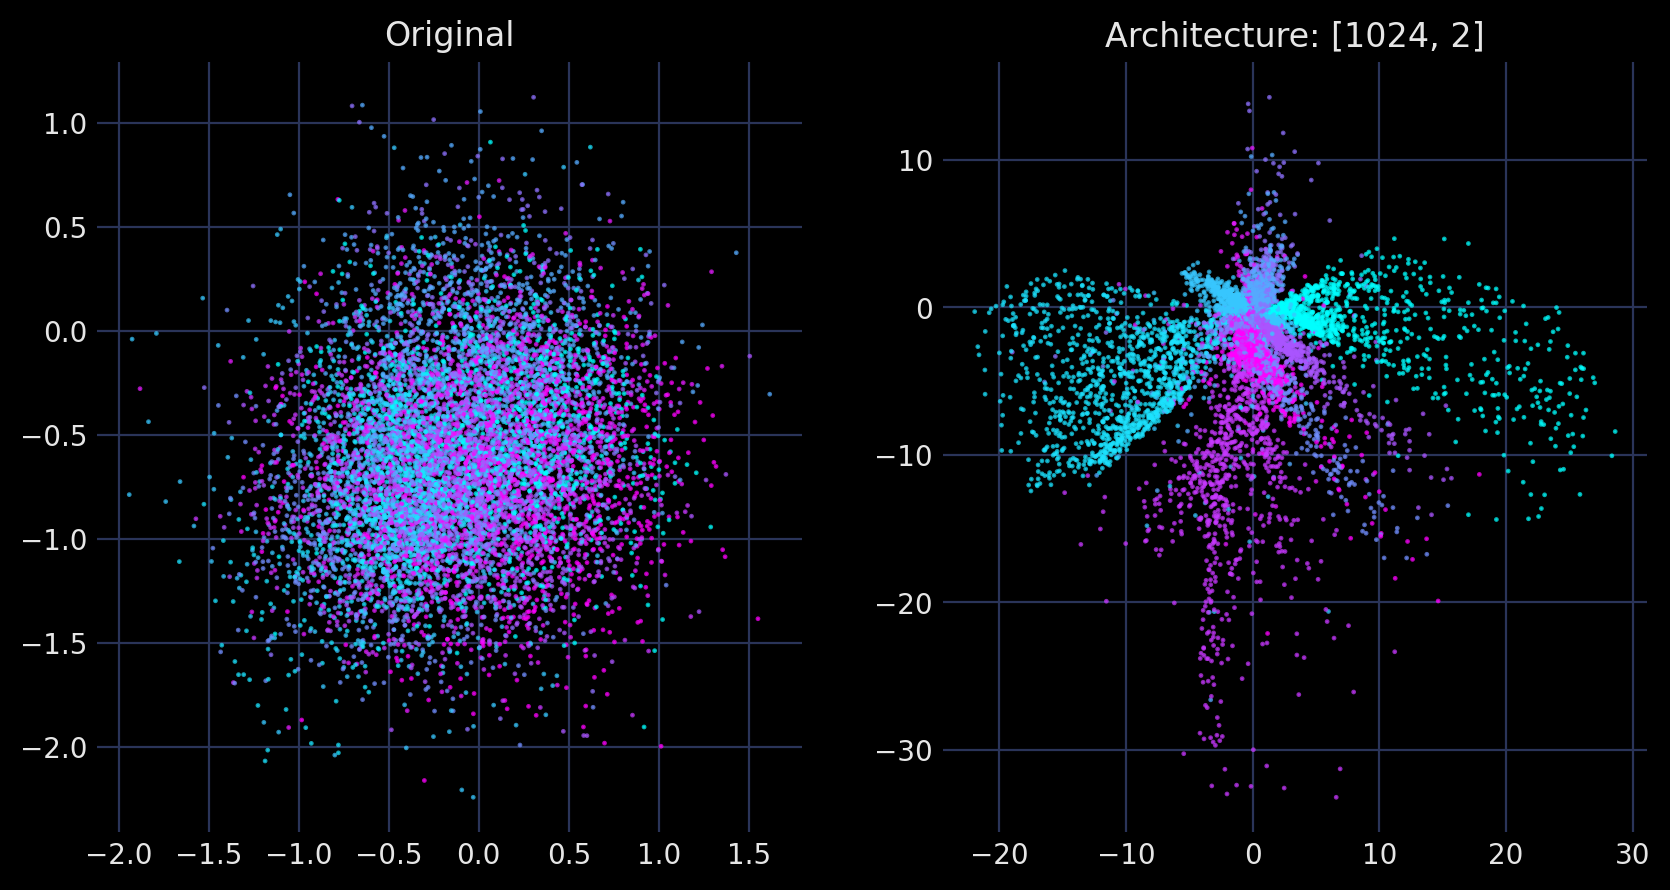

In [59]:
with plt.style.context('cyberpunk'): 
    figure, axes = plt.subplots(1, 2, figsize=(10, 5))
    cbar = axes[0].scatter(points_dummy_x, points_dummy_y, c=labels_dummy, s=0.5, alpha=0.7)
    axes[1].scatter(points_trained_x, points_trained_y, c=labels_trained, s=0.5, alpha=0.7)
    for ax, title in zip(axes.ravel(), ['Original', 'Architecture: [1024, 2]']):
        enhance_plot(figure, axes=ax, dpi=200)
        ax.set(title=title)

Let's now compare latent spaces for all trained models

In [66]:
def compare_latent_spaces(models_dict, figure_layout, figsize, dataset, s=0.5, alpha=0.7):
    with plt.style.context('cyberpunk'): 
        figure, axes = plt.subplots(*figure_layout, figsize=figsize)
        for (model_name, model), ax in zip(models_dict.items(), axes.ravel()):
            points_x, points_y, labels = get_latent_space_points(
                model.encoder, dataset)
            ax.scatter(points_x, points_y, c=labels, s=s, alpha=alpha)
            enhance_plot(figure, ax, dpi=200)
            ax.axis(False)
            ax.set(title=model_name)
    return figure, axes

100%|██████████| 10000/10000 [00:09<00:00, 1035.73it/s]


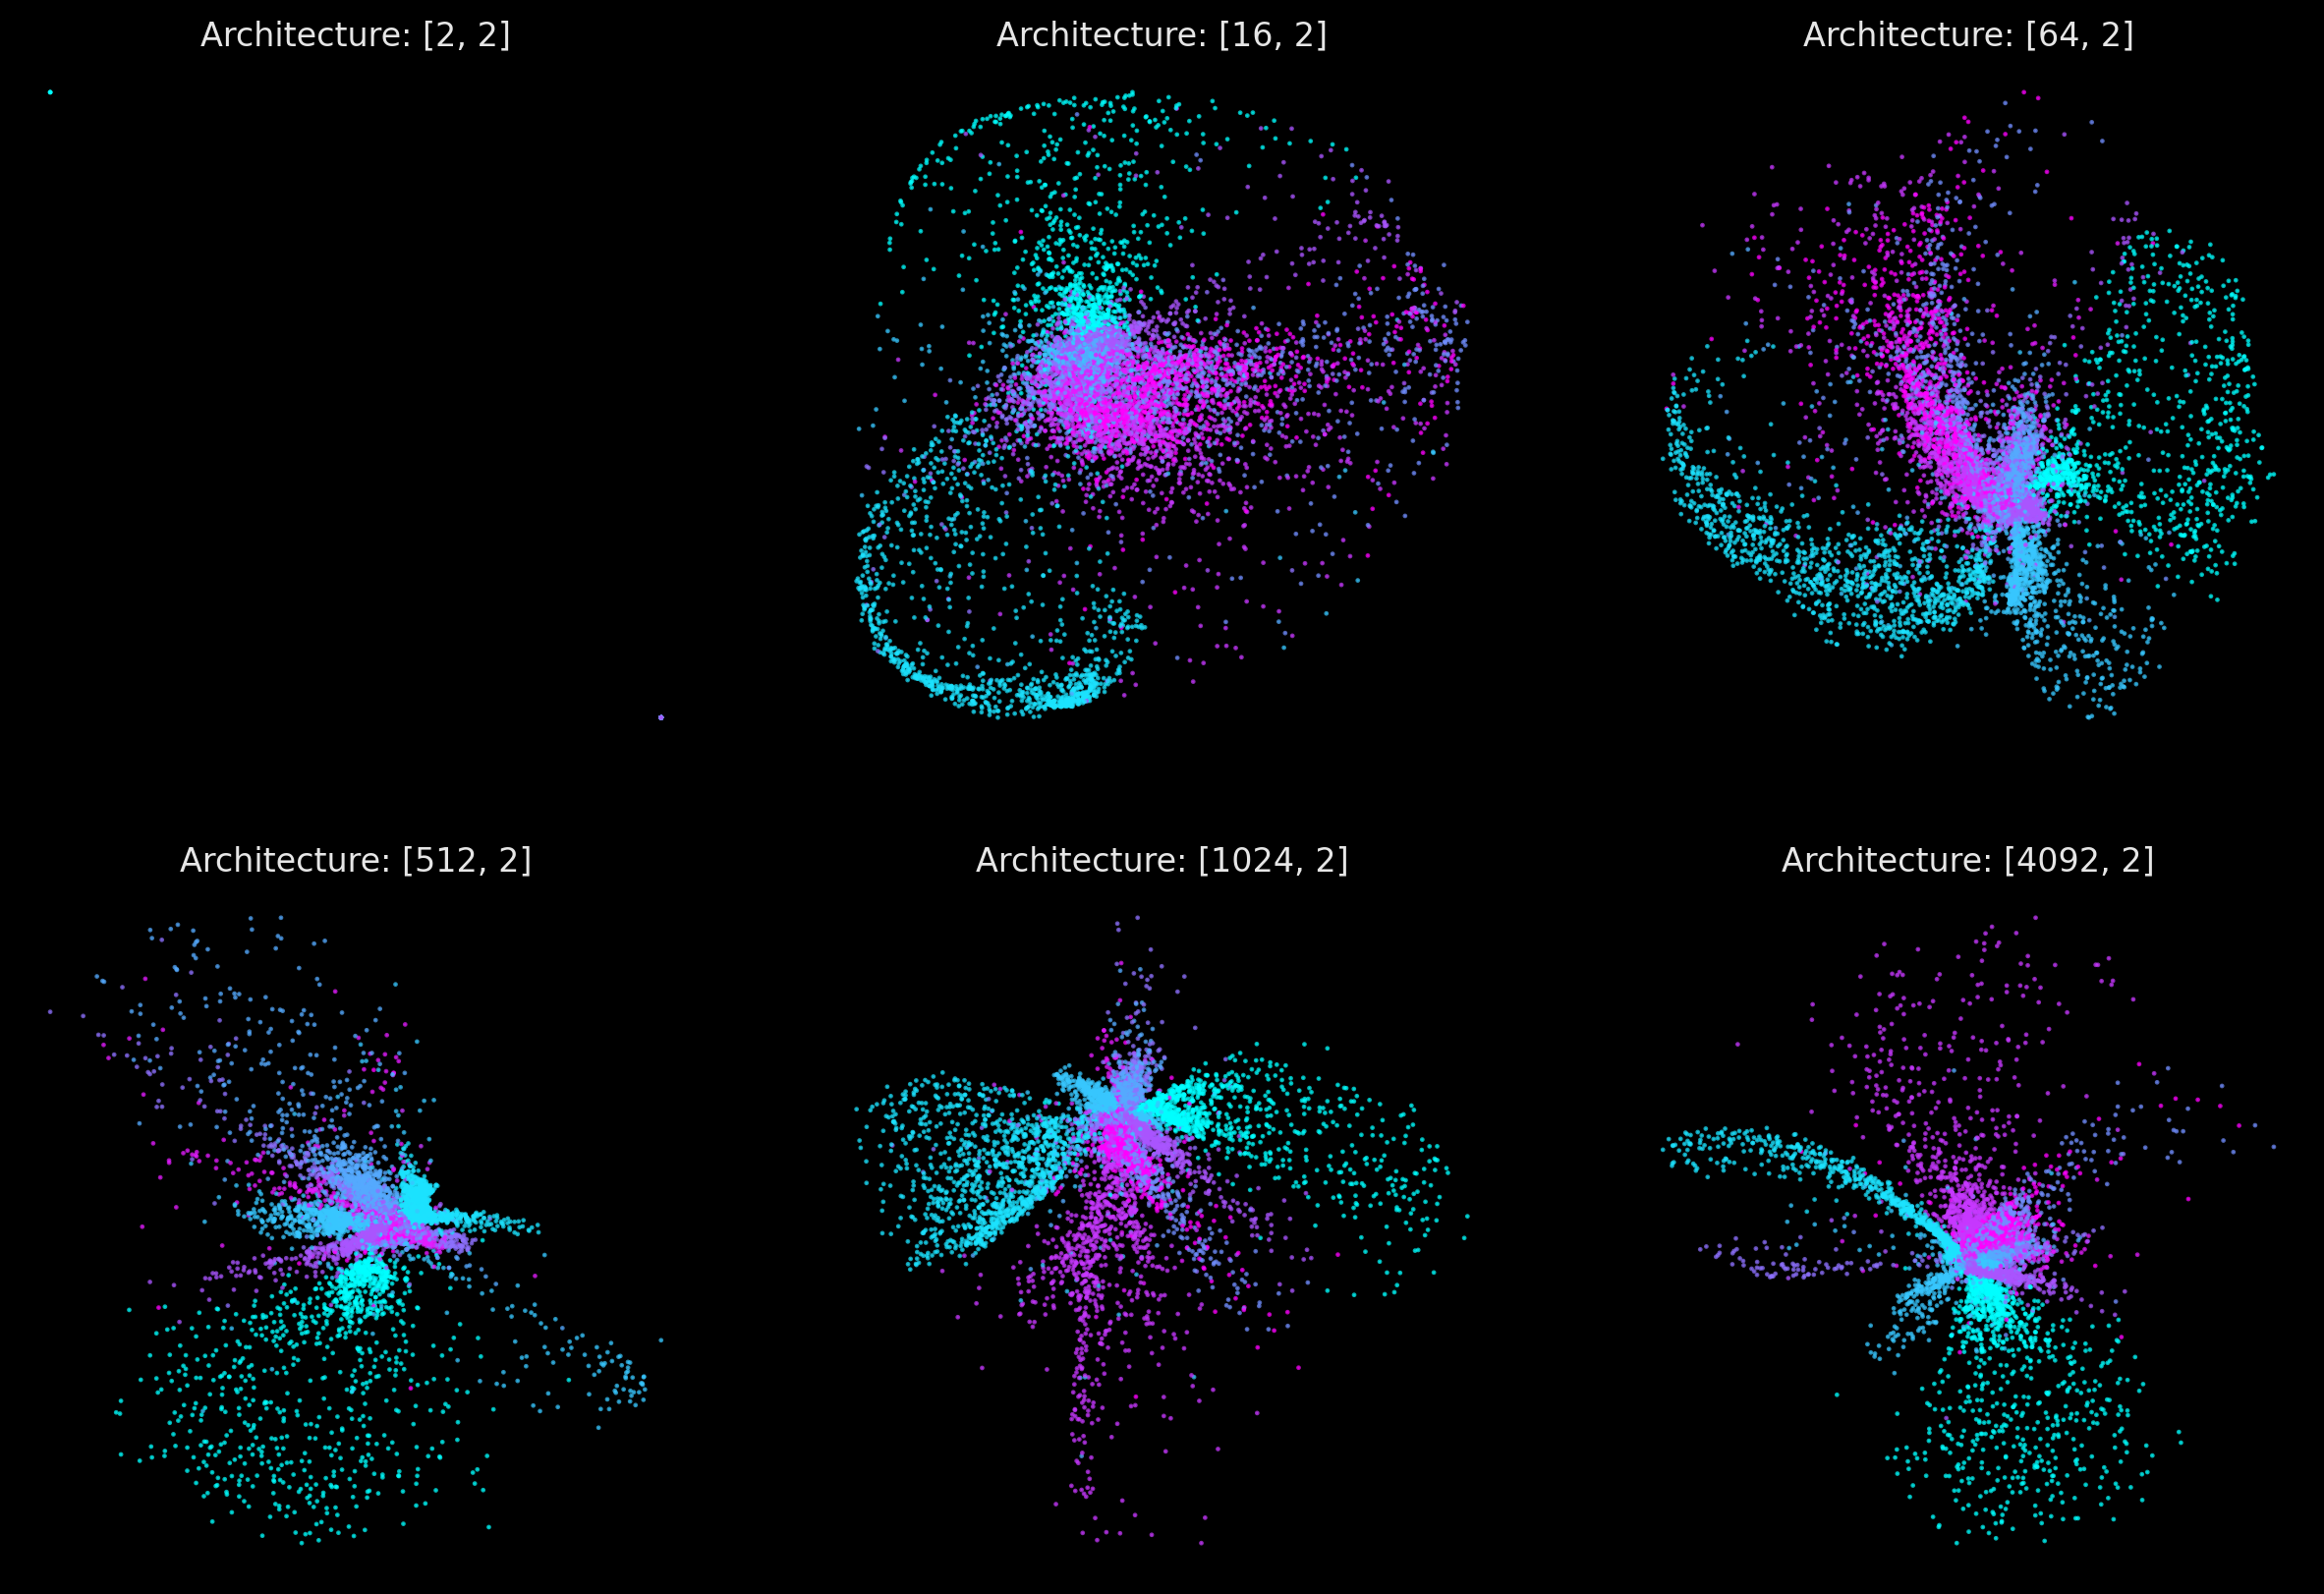

In [68]:
compare_latent_spaces(trained_models, (2, 3), (15, 10), mnist_test);

Now Let's see if adding a third latent space dimension will improve performance

In [71]:
hidden_layers = [1024]
latent_space_dim = 3
architecture = hidden_layers + [latent_space_dim]
model_title = f'Architecture: {architecture}'
model_path_file = model_path + model_title
autoencoder = DenseAutoencoder(
    input_shape=input_shape,
    encoder_hidden_layers=hidden_layers,
    latent_space_dim=latent_space_dim
).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE)
train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
loss_results[architecture] = autoencoder_train_loop(
        model=autoencoder, 
        dataloader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=DEVICE,
        epochs=NUM_EPOCHS
)
trained_models[model_title] = autoencoder
torch.save(obj=autoencoder.state_dict(), 
           f=f'./models/9.1-DenseAutoencoders/DenseAutoencoder{architecture}.pth')

100%|██████████| 30/30 [05:16<00:00, 10.56s/it, loss=0.616]


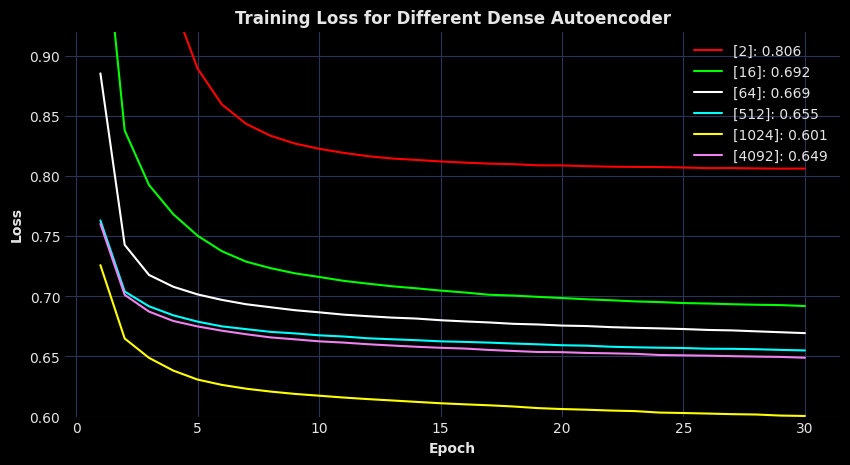

In [73]:
if loss_results:    
    with plt.style.context('cyberpunk'):
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        config = {'title': f'Training Loss for Different Dense Autoencoder', 
                  'xlabel': 'Epoch', 'ylabel': 'Loss', 'ylim': [0.6, 0.92]}
        plot_loss(fig, ax, NUM_EPOCHS, loss_results, config, colors)

We can see that adding just one more dimension massively reduces the loss

100%|██████████| 10000/10000 [00:03<00:00, 2518.58it/s]


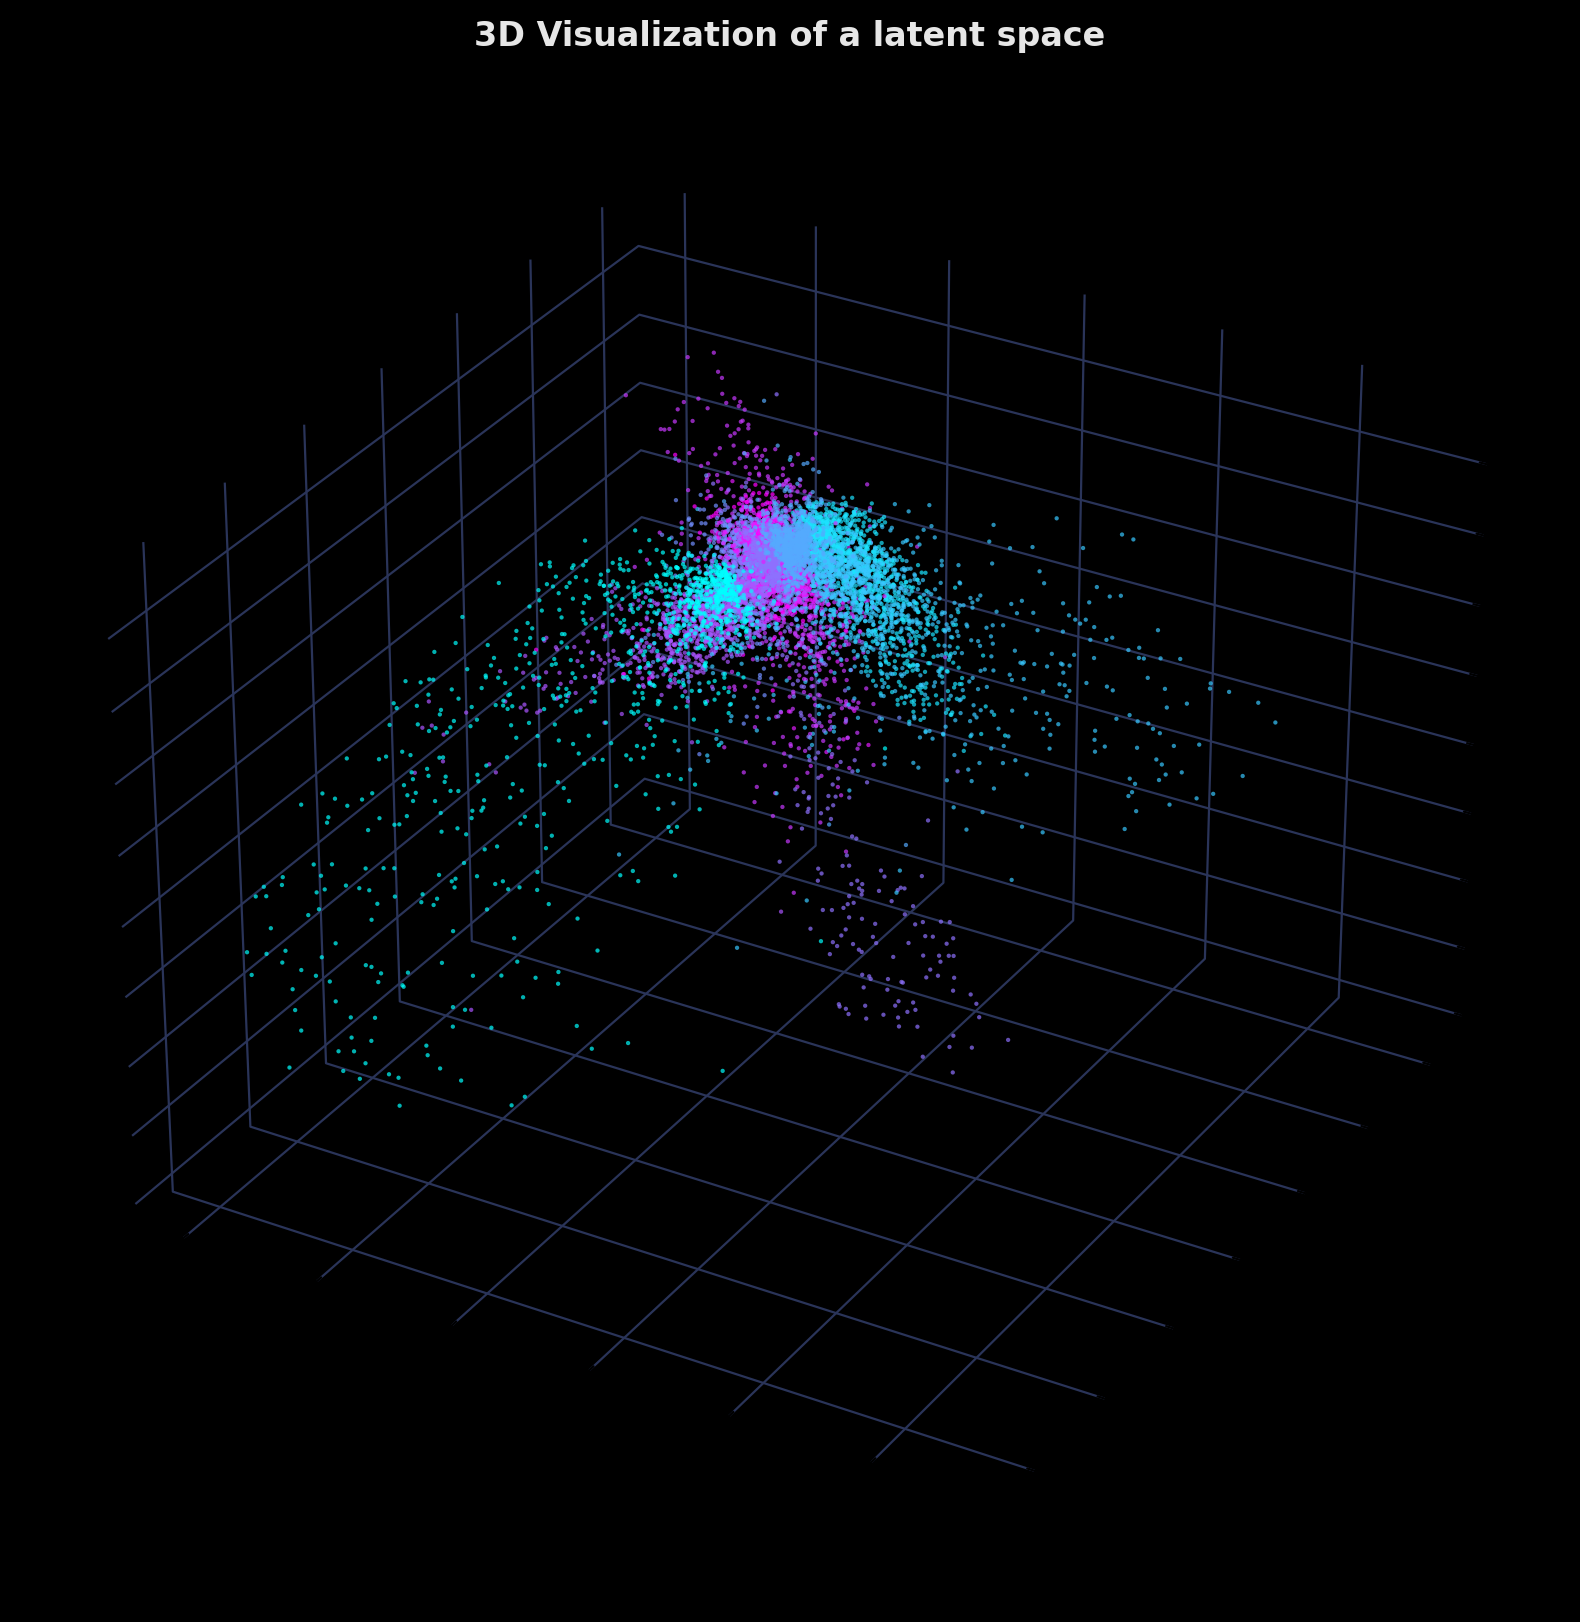

In [121]:
with (plt.style.context('cyberpunk')):
    figure, axes = plt.subplots(1, 1, subplot_kw=dict(projection='3d'), figsize=(10, 10))
    space_points, labels = get_latent_space_points(
        trained_models[model_title].encoder, mnist_test)
    axes.scatter(*space_points, c=labels, s=0.3, alpha=0.7)
    axes.set(title='3D Visualization of a latent space',
             xlim=[min(space_points[0]), max(space_points[0])],
             ylim=[min(space_points[1]), max(space_points[1])],
             zlim=[min(space_points[2]), max(space_points[2])],)
    for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
        axis.set_pane_color((1, 1, 1, 0))
        axis.set_tick_params(which='major', color='black')
    axes.set_xticklabels([])
    axes.set_yticklabels([])
    axes.set_zticklabels([])
    enhance_plot(figure, axes, dpi=200)